## Stereo camera calibration

This week you'll be provided with a set of stereo images, and your task is to undistort and rectify the images, such that they can be used with the stereo depth reconstruction you made on day 6. You are still not allowed to use opencv functions for block matching/template matching, however you are free to use opencv when undistorting the images. It is recommended that you finish the exercises from Monday before continuing with the weekly project.

The image sets are found in the attached zip-file. Start with the rs.zip and move on to mynteye.zip once you have it working. The physical dimensions of each square of the pattern are 33.6 x 33.6 mm.

Hint: You'll have to undistort the images before rectifying them.

Hint: Some of the relevant functions you'll be using can be found here.

In [9]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

In [10]:
# Implement the number of vertical and horizontal corners
nb_vertical = 6
nb_horizontal = 9

images = glob.glob('./mynteye/*.png')
assert images

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nb_horizontal*nb_vertical,3), np.float32)
objp[:,:2] = np.mgrid[0:nb_vertical,0:nb_horizontal].T.reshape(-1,2)

objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Implement findChessboardCorners here
    ret, corners = cv2.findChessboardCorners(img, (nb_horizontal, nb_vertical),flags=cv2.CALIB_CB_FAST_CHECK)


    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nb_vertical,nb_horizontal), corners,ret)
        cv2.imshow('img',img)
        cv2.waitKey(100)

cv2.destroyAllWindows()

In [11]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [19]:
def undistort(img, mtx, dist):
    h,  w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
    # undistort
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
    x,y,w,h = roi
    dst = dst[y:y+h, x:x+w]
    return dst

In [20]:
undistorted_imgs = []
for fname in images:
    img = cv2.imread(fname)
    undistorted_imgs.append(undistort(img, mtx, dist))

In [21]:
for img in undistorted_imgs:
        cv2.imshow('img',img)
        cv2.waitKey(100)

cv2.destroyAllWindows()

<Figure size 432x288 with 0 Axes>

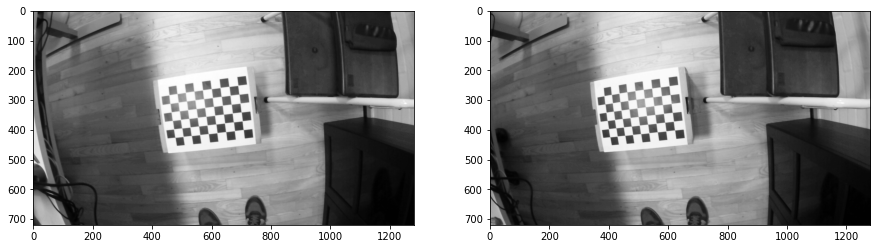

In [25]:
plt.gray()
img_left = cv2.imread('./mynteye/left-0004.png')
img_right = cv2.imread('./mynteye/right-0004.png')

img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
gray_left = cv2.cvtColor(img_left, cv2.COLOR_RGB2GRAY)

img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)
gray_right= cv2.cvtColor(img_right, cv2.COLOR_RGB2GRAY)

f, axarr = plt.subplots(1,2, figsize = (15,15))
axarr[0].imshow(gray_left)
axarr[1].imshow(gray_right)

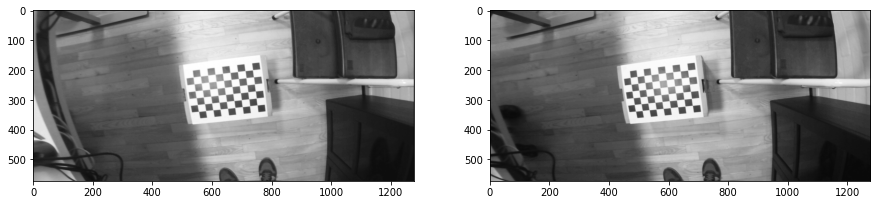

In [27]:
gray_left_undistort = undistort(gray_left, mtx, dist)
gray_right_undistort = undistort(gray_right, mtx, dist)
f, axarr = plt.subplots(1,2, figsize = (15,15))
axarr[0].imshow(gray_left_undistort)
axarr[1].imshow(gray_right_undistort)


In [31]:
img1 = gray_left_undistort
img2 = gray_right_undistort

sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

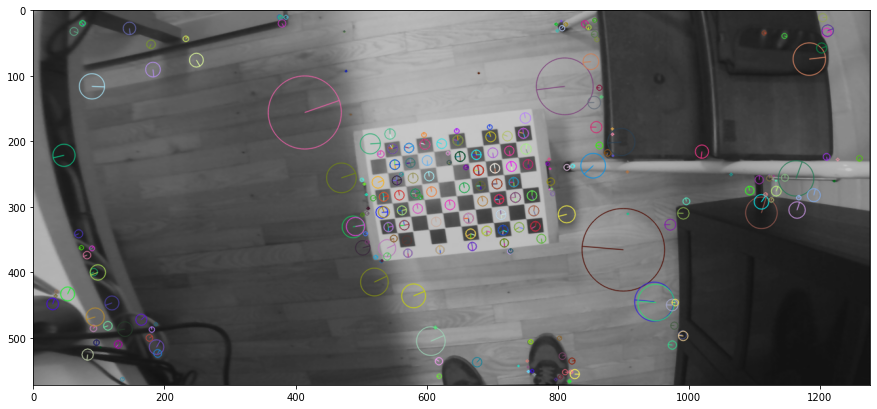

In [36]:
imgSift = cv2.drawKeypoints(
    img1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(15,15))
plt.imshow(imgSift)

In [38]:

# Match keypoints in both images
# Based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Keep good matches: calculate distinctive image features
# Lowe, D.G. Distinctive Image Features from Scale-Invariant Keypoints. International Journal of Computer Vision 60, 91–110 (2004). https://doi.org/10.1023/B:VISI.0000029664.99615.94
# https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf
matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        # Keep this keypoint pair
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

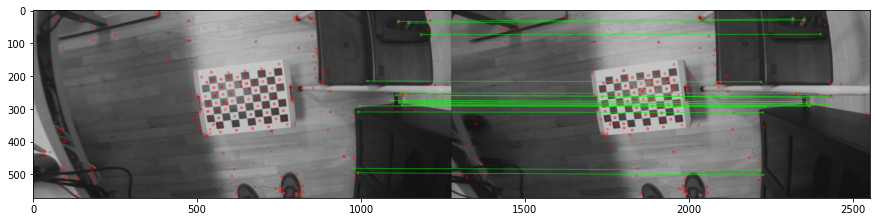

In [42]:
# Draw the keypoint matches between both pictures
# Still based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask[300:500],
                   flags=cv2.DrawMatchesFlags_DEFAULT)

keypoint_matches = cv2.drawMatchesKnn(
    img1, kp1, img2, kp2, matches[300:500], None, **draw_params)
plt.figure(figsize=(15,15))
plt.imshow(keypoint_matches)

In [45]:
# ------------------------------------------------------------
# STEREO RECTIFICATION

# Calculate the fundamental matrix for the cameras
# https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# We select only inlier points
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]

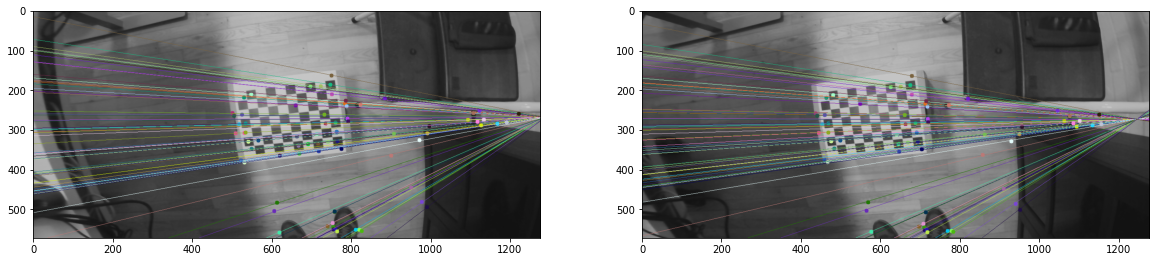

In [59]:
# Visualize epilines
# Adapted from: https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
def drawlines(img1src, img2src, lines, pts1src, pts2src):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c = img1src.shape
    img1color = cv2.cvtColor(img1src, cv2.COLOR_GRAY2BGR)
    img2color = cv2.cvtColor(img2src, cv2.COLOR_GRAY2BGR)
    # Edit: use the same random seed so that two images are comparable!
    np.random.seed(0)
    for r, pt1, pt2 in zip(lines, pts1src, pts2src):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1color = cv2.line(img1color, (x0, y0), (x1, y1), color, 1)
        img1color = cv2.circle(img1color, tuple(pt1), 5, color, -1)
        img2color = cv2.circle(img2color, tuple(pt2), 5, color, -1)
    return img1color, img2color


# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(
    pts2.reshape(-1, 1, 2), 2, fundamental_matrix)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(
    pts1.reshape(-1, 1, 2), 1, fundamental_matrix)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

f, axarr = plt.subplots(1,2, figsize = (20,20))
axarr[0].imshow(img5)
axarr[1].imshow(img3)
plt.show()

In [55]:
# Stereo rectification (uncalibrated variant)
# Adapted from: https://stackoverflow.com/a/62607343
h1, w1 = img1.shape
h2, w2 = img2.shape
_, H1, H2 = cv2.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1)
)

In [56]:
# Undistort (rectify) the images and save them
# Adapted from: https://stackoverflow.com/a/62607343
img1_rectified = cv2.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv2.warpPerspective(img2, H2, (w2, h2))
cv2.imwrite("rectified_1.png", img1_rectified)
cv2.imwrite("rectified_2.png", img2_rectified)

True

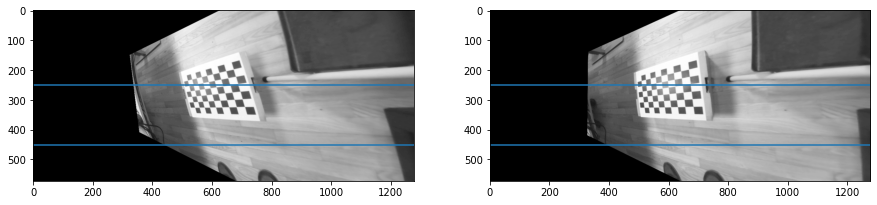

In [58]:
# Draw the rectified images
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1_rectified, cmap="gray")
axes[1].imshow(img2_rectified, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.savefig("rectified_images.png")
plt.show()

In [ ]:
kernel_size = (15,15)

def absoluteDifference(img1, img2):
    diff = cv2.absdiff(img1, img2)
    return diff

def SAD(img1, img2):
    return np.sum(absoluteDifference(img1, img2))

def findBestInRow(match, span, column, scope):
    kernel_size =  len(match[0]), len(match)
    span_size = len(span[0]), len(span),
    best_score = float("inf")
    best_start = -1
    start_range = column - scope*kernel_size[0] if column - scope*kernel_size[0] > 0 else 0
    end_range = column+ scope*kernel_size[0] if column+ scope*kernel_size[0] < span_size[0] - kernel_size[0] else span_size[0] - kernel_size[0] + 1
    for start in range(start_range, end_range): #span_size[0] - kernel_size[0] + 1):
        kernel = span[:, start:start+kernel_size[0]]
        score = SAD(match, kernel)
        if  score < best_score:
            best_score = score
            best_start = start
            
    return best_start, best_score  

def disparity(gray_left, gray_right):
    scope = 5
    best_starts = []
    for row in range(len(gray_left) - kernel_size[1] + 1):
        best_starts.append([])
        for column in range(len(gray_left[0]) - kernel_size[0] + 1):
            kernel = gray_left[row:row+kernel_size[1], column:column+kernel_size[0]]
            best_start, best_score = findBestInRow(kernel, gray_right[row:row+kernel_size[1], :], column, scope)
            best_starts[row].append((best_start, best_score))
    return np.array(best_starts)

best_starts = disparity(img1_rectified, img2_rectified)

img1_rectified_cropped = img1_rectified[0:len(img1_rectified) - kernel_size[0] + 1, 0:len(img1_rectified[1]) - kernel_size[1]+1]

img1_rectified_cropped_ind = np.zeros_like(img1_rectified_cropped).astype("int16")
for i in range(len(img1_rectified_cropped_ind)):
    for j in range(len(img1_rectified_cropped_ind[0])):
        img1_rectified_cropped_ind[i,j] = j

disparity = cv2.absdiff(img1_rectified_cropped_ind, best_starts[:,:,0].astype("int16"))   
plt.imshow(disparity)